In [54]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import f1_score
import pickle

# import own functions
from ipynb.fs.full.Functions import load_train_test_data, model_eval

In [122]:
# load the data
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')

# load the train/test data
X_train, X_test, y_train, y_test = load_train_test_data(df)
num_classes = y_train.nunique()

A snippet of the data:


,duration,mean,median,max,min,var,std,speaking_rate,articulation_rate,asd,...,lpcmfccs_local9_max,lpcmfccs_local9_min,lpcmfccs_local10_mean,lpcmfccs_local10_var,lpcmfccs_local10_max,lpcmfccs_local10_min,lpcmfccs_local11_mean,lpcmfccs_local11_var,lpcmfccs_local11_max,lpcmfccs_local11_min
241,1.080531,0.798864,0.120244,-1.545379,-0.652108,0.523898,0.658707,-1.111672,-0.558179,0.331673,...,-0.308694,0.084472,0.271426,-0.218007,-0.057589,0.313795,0.267861,-0.227202,-0.111190,0.307516
364,0.720034,-1.009939,-0.702861,-0.141995,-0.651093,-0.969902,-1.111441,-0.398964,0.017716,-0.177987,...,0.711811,-0.075413,-0.780710,-0.043641,0.130479,-0.665620,-0.891269,-0.010428,0.017714,-0.722238
209,1.225277,-0.809615,-0.966255,0.733353,1.901097,-0.657665,-0.656852,-0.139340,0.054715,-0.207189,...,1.255242,0.065525,-0.731827,0.102518,-0.035001,-1.208029,-0.794909,0.149507,-0.097226,-1.265853
430,0.310436,-0.863672,-0.684753,0.296739,-0.651347,-0.873055,-0.962529,0.930037,0.782669,-0.712995,...,-0.570754,-0.120425,0.484469,-0.230758,0.181230,0.541156,0.519439,-0.246612,0.057740,0.577385
309,-0.541554,1.990422,2.001863,-1.172855,-0.651601,1.882264,1.798970,1.191835,1.071873,-0.883360,...,-0.591040,0.194870,0.515836,-0.230930,-0.206997,0.556228,0.565981,-0.247006,-0.185268,0.598848


There are 454 entries with 249 columns in the training data.
There are 81 entries with 249 columns in the testing data.


In [123]:
# split test set into validation and test data
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test')

A snippet of the data:


,duration,mean,median,max,min,var,std,speaking_rate,articulation_rate,asd,...,lpcmfccs_local9_max,lpcmfccs_local9_min,lpcmfccs_local10_mean,lpcmfccs_local10_var,lpcmfccs_local10_max,lpcmfccs_local10_min,lpcmfccs_local11_mean,lpcmfccs_local11_var,lpcmfccs_local11_max,lpcmfccs_local11_min
50,-0.467142,1.539161,-0.322586,0.530244,-0.652108,2.430749,2.197872,-1.446222,-0.420712,0.199741,...,-0.450101,0.157607,0.426546,-0.228943,-0.150820,0.440161,0.448570,-0.243507,-0.167025,0.452311
117,-0.985224,0.249976,0.339190,-0.054813,-0.652108,-0.041486,0.085751,1.483441,1.394006,-1.056562,...,0.669442,0.198621,-1.832046,0.366989,-0.207596,-0.623751,-1.939841,0.469775,-0.190018,-0.679760
190,-0.678938,0.829002,-0.301186,-1.202544,-0.651347,1.323608,1.360837,-1.089735,-0.503961,0.278790,...,-0.108350,0.200731,0.283543,-0.208727,-0.207894,0.128361,0.288420,-0.216085,-0.205875,0.103808
285,-1.281349,-0.185806,-0.255092,-1.059048,-0.651601,-0.143899,-0.027428,-0.262226,-0.534406,0.308346,...,-0.592627,0.195681,0.520823,-0.230936,-0.207496,0.557323,0.574294,-0.247029,-0.187369,0.600547
310,0.303987,2.509715,2.604376,0.672797,-0.652108,2.694004,2.380136,-0.145141,-0.405064,0.185164,...,-0.596886,0.178225,0.523121,-0.230939,-0.179220,0.560123,0.578755,-0.247037,-0.178977,0.605140


There are 40 entries with 249 columns in the validation data.
There are 41 entries with 249 columns in the testing data.


In [124]:
# define a tabluar dataset with torch
class TabularDataset(Dataset):
    def __init__(self, data, target):
        self.data = data
        self.target = target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data.iloc[idx].values, dtype=torch.float)
        y = torch.tensor(self.target.iloc[idx], dtype=torch.long)
        return x, y

In [125]:
# GPU device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)

# set hyperparameters
BATCH_SIZE = 32
HIDDEN_SIZE = 64
EPOCHS = 25
patience = 2

Device state: cpu


In [33]:
# define train, test, and val loader
torch.manual_seed(0) # set random seed
train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True)

# MLP-FFNN

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.layer3(x)
        return x

In [34]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.activation2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.stack([torch.Tensor(f) for f in x])  # Convert input to tensor if not already
        x = x.view(x.size(0), -1)  # Flatten input if necessary
        x = self.layer1(x)
        x = self.activation1(x)
        x = self.layer2(x)
        x = self.activation2(x)
        x = self.layer3(x)
        return x

In [35]:
# define model, optimizer, and criterion
model = MLP(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [36]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, batch_size=BATCH_SIZE, num_epochs=EPOCHS, patience=patience):
    # set random seed
    torch.manual_seed(0)
    
    train_losses = []
    val_losses = []
    val_f1_scores = []
    best_val_f1_score = 0.0
    no_improvement_count = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                val_preds.extend(predicted.tolist())
                val_labels.extend(labels.tolist())
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        val_f1 = f1_score(val_labels, val_preds, average='macro')
        val_f1_scores.append(val_f1)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1 Macro: {val_f1:.4f}")
        
        if val_f1 > best_val_f1_score:
            best_val_f1_score = val_f1
            best_model_weights = model.state_dict()
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count == patience:
                print(f"No improvement in val F1 macro score for {patience} epochs, stopping training early")
                break
        
    model.load_state_dict(best_model_weights)
    return model, train_losses, val_losses, val_f1_scores

In [ ]:
def train_mlp(X, y, hidden_sizes, batch_size=64, learning_rate=0.01, num_epochs=100, 
              validation_split=0.2, patience=5, metric='accuracy', random_state=None):
    """
    Train a multilayer perceptron (MLP) for classification.

    Args:
        X (list or numpy.ndarray): Input features. Can be a list of arrays or a 2D array.
        y (list or numpy.ndarray): Target labels.
        hidden_sizes (list): Sizes of the hidden layers.
        batch_size (int, optional): Batch size for training. Defaults to 64.
        learning_rate (float, optional): Learning rate for training. Defaults to 0.01.
        num_epochs (int, optional): Number of epochs to train for. Defaults to 100.
        validation_split (float, optional): Fraction of the data to use for validation. Defaults to 0.2.
        patience (int, optional): Number of epochs to wait before early stopping if validation loss does not improve. Defaults to 5.
        metric (str, optional): Metric to use for early stopping. Can be 'accuracy' or 'f1_macro'. Defaults to 'accuracy'.
        random_state (int or None, optional): Random state for reproducibility. Defaults to None.

    Returns:
        tuple: Tuple containing the trained MLP and the history of training and validation metrics.
    """
    # Determine the input feature size
    if isinstance(X, list):
        feature_lengths = [len(x) for x in X]
        input_feature_size = sum(feature_lengths)
        X = [pad_vector(x, max(feature_lengths)) for x in X]
        X = torch.tensor(X, dtype=torch.float)
    else:
        input_feature_size = X.shape[1]

    # Convert the target labels to a tensor
    y = torch.tensor(y, dtype=torch.long)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=random_state)

    # Create data loaders for the training and validation sets
    train_data = TensorDataset(X_train, y_train)
    train_loader


In [10]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.8222, Val Loss: 1.6959, Val F1 Macro: 0.3294
Epoch 2/25, Train Loss: 1.4374, Val Loss: 1.5506, Val F1 Macro: 0.4514
Epoch 3/25, Train Loss: 1.1338, Val Loss: 1.2720, Val F1 Macro: 0.4928
Epoch 4/25, Train Loss: 0.9228, Val Loss: 0.9188, Val F1 Macro: 0.5450
Epoch 5/25, Train Loss: 0.7393, Val Loss: 0.9221, Val F1 Macro: 0.6277
Epoch 6/25, Train Loss: 0.6127, Val Loss: 0.6969, Val F1 Macro: 0.6320
Epoch 7/25, Train Loss: 0.4600, Val Loss: 0.6905, Val F1 Macro: 0.6696
Epoch 8/25, Train Loss: 0.3719, Val Loss: 0.7409, Val F1 Macro: 0.7575
Epoch 9/25, Train Loss: 0.3181, Val Loss: 0.8802, Val F1 Macro: 0.7985
Epoch 10/25, Train Loss: 0.2523, Val Loss: 0.6630, Val F1 Macro: 0.8397
Epoch 11/25, Train Loss: 0.2276, Val Loss: 0.6531, Val F1 Macro: 0.8473
Epoch 12/25, Train Loss: 0.1719, Val Loss: 0.7929, Val F1 Macro: 0.8515
Epoch 13/25, Train Loss: 0.1406, Val Loss: 0.4136, Val F1 Macro: 0.8384
Epoch 14/25, Train Loss: 0.1217, Val Loss: 0.7844, Val F1 Macro: 0.8975
E


Evaluation: f1_score
99.57% for the train data
81.58% for the test data

Evaluation: accuracy_score
99.56% for the train data
85.37% for the test data

Evaluation: precision_score
99.63% for the train data
89.90% for the test data

Evaluation: recall_score
99.52% for the train data
80.95% for the test data

Evaluation: confusion_matrix of test predictions


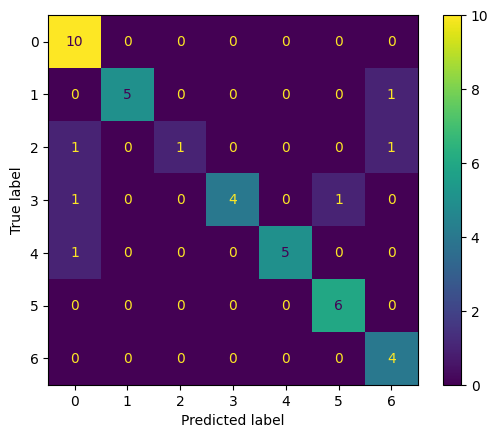


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'sadness(6)']



In [11]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

In [12]:
# save model
pickle.dump(model, open('../results/models/MLPFFNN_best_model_all_numerical_features.pkl', 'wb'))

# GFFNN (skip connections)

In [13]:
class MLPWithSkip(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPWithSkip, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        self.skip_connection = nn.Linear(input_size, hidden_size)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        hidden1 = self.relu(self.fc1(x))
        hidden2 = self.relu(self.fc2(hidden1))
        
        # Apply skip connection from input to second hidden layer
        skip = self.skip_connection(x)
        hidden2_skip = hidden2 + skip
        
        output = self.fc3(hidden2_skip)
        return output

In [14]:
# define model, optimizer, and criterion
model = MLPWithSkip(input_size=len(X_train.columns), hidden_size=HIDDEN_SIZE, output_size=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [15]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

Epoch 1/25, Train Loss: 1.4954, Val Loss: 1.2778, Val F1 Macro: 0.4518
Epoch 2/25, Train Loss: 0.9119, Val Loss: 1.1691, Val F1 Macro: 0.5547
Epoch 3/25, Train Loss: 0.6864, Val Loss: 0.9944, Val F1 Macro: 0.5643
Epoch 4/25, Train Loss: 0.5492, Val Loss: 0.6039, Val F1 Macro: 0.6753
Epoch 5/25, Train Loss: 0.4348, Val Loss: 0.7281, Val F1 Macro: 0.6554
Epoch 6/25, Train Loss: 0.3897, Val Loss: 0.6064, Val F1 Macro: 0.7167
Epoch 7/25, Train Loss: 0.2927, Val Loss: 0.5481, Val F1 Macro: 0.8190
Epoch 8/25, Train Loss: 0.2425, Val Loss: 0.5449, Val F1 Macro: 0.8190
Epoch 9/25, Train Loss: 0.2079, Val Loss: 0.7370, Val F1 Macro: 0.7951
No improvement in val F1 macro score for 2 epochs, stopping training early



Evaluation: f1_score
96.50% for the train data
83.35% for the test data

Evaluation: accuracy_score
96.48% for the train data
87.80% for the test data

Evaluation: precision_score
96.78% for the train data
90.48% for the test data

Evaluation: recall_score
96.33% for the train data
82.14% for the test data

Evaluation: confusion_matrix of test predictions


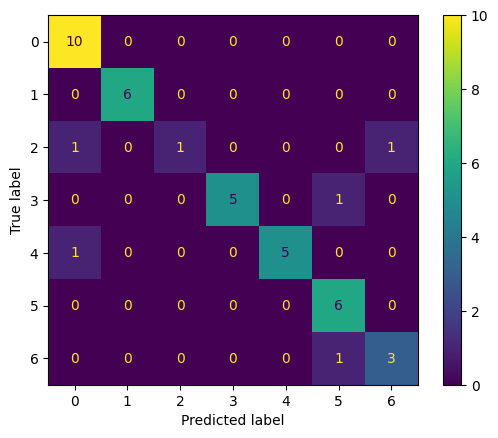


Hard cases for the model:

Label: disgust(2)
Hard cases of false negatives: ['anger(0)', 'sadness(6)']

Label: sadness(6)
Hard cases of false negatives: ['neutral(5)']
Hard cases of false positives: ['disgust(2)']



In [16]:
model_eval(model, X_train, X_test, y_train, y_test, confusion=True)

# Test for features paper 1

In [138]:
# load dataframe with all entries (not only numerical) - note that they are not scaled / further preprocessed
df = pd.read_pickle('../results/df_prep_numerical_only.pkl')
df_all = pd.read_pickle('../results/extracted_features_modified.pkl')

In [156]:
# selection of features (mean pitch, mean energy, pitch variance, skew of logarithmic pitch, range of logarithmic pitch,
# range of logarithmic energy)
df_paper1 = df_all[['lpc', 'log_energy_entropy', 'shannon_entropy', 'threshold_entropy',
                   'sure_entropy', 'rms', 'f0', 'f1', 'f2', 'f3', 'f4']].copy()
df_paper1 = pd.merge(df[['label', 'var', 'min', 'median']], df_paper1, left_index=True, right_index=True)

In [157]:
# small preprocess: convert var, min, median also to arrays
for feature in ['var', 'min', 'median']:
    df_paper1[feature] = df_paper1[feature].apply(lambda x: np.array([x]))
df_paper1.head()

,label,var,min,median,lpc,log_energy_entropy,shannon_entropy,threshold_entropy,sure_entropy,rms,f0,f1,f2,f3,f4
0,4,[-1.1077997442702396],[0.9120471048692147],[-1.0600887065143705],"[1.0, -1.3784221, 0.69826585, -0.44159302, 0.2...","[0.8509675, 0.37695062, 0.0, 0.2376355, 0.5616...","[0.0, 0.24065953946723917, 0.3056793132108977,...","[0.0, 0.0, 0.025390625, 0.1650390625, 0.390625...","[0.0, 0.5340640447023426, 1.0, 0.7605845690952...","[0.0011372825, 0.0012941798, 0.012547005, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 141.8...","[366.139456692797, 406.2651059763895, 464.1082...","[1888.5991203215656, 1888.0465037258002, 1912....","[2622.348075806301, 2640.683019940289, 2646.09...","[3650.5303260741794, 3616.192663764363, 3618.7..."
1,5,[-0.18546201004620894],[-0.6510932114283963],[-0.9893016606113726],"[1.0, -1.5548326, 0.84461135, -0.39231607, 0.1...","[0.77799094, 0.3398105, 0.007011771, 0.2680765...","[0.0, 0.29996965968948575, 0.4304300402658555,...","[0.0, 0.0, 0.00830078125, 0.1806640625, 0.3408...","[0.0, 0.54618213281419, 1.0, 0.942677914773956...","[0.0023372034, 0.002490107, 0.0158029, 0.09679...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[455.1342622238156, 474.13099161767065, 511.05...","[1710.5641941221943, 1677.8259451018241, 1679....","[2032.8323008676925, 2660.126131933908, 2546.2...","[2662.473597581669, 3074.6056154602775, 3273.4..."
2,0,[-0.13085934083665982],[-0.6521084024115413],[-0.6765216903423126],"[1.0, -1.366485, 0.840961, -0.37688726, 0.1708...","[0.6902827, 0.34663463, 0.0, 0.18346202, 0.434...","[0.0, 0.14975822138778494, 0.2186258363367165,...","[0.0, 0.0, 0.0, 0.0908203125, 0.271484375, 0.4...","[0.11014711429649193, 0.5811014711429651, 0.88...","[0.0003959035, 0.0005016159, 0.000568984, 0.04...","[0.0, 0.0, 0.0, 0.0, 0.0, 155.56349186104043, ...","[412.2984102092574, 457.16085329536537, 494.73...","[1910.583625157631, 1912.489911862922, 1902.88...","[2687.4015293731413, 2687.012378039779, 2689.1...","[3211.25186744456, 3124.9491229330333, 3162.11..."
3,4,[-0.20664944494006618],[-0.024212779336319757],[-0.5217779155776198],"[1.0, -1.1566716, 0.09517725, 0.10888941, 0.07...","[0.7458475, 0.3505782, 0.21594667, 0.49595094,...","[0.0, 0.24714613308195366, 0.24408760946910923...","[0.0, 0.0, 0.15966796875, 0.369140625, 0.46875...","[0.0, 0.5325571366968522, 0.5741699008193186, ...","[0.0020485923, 0.004919004, 0.10309043, 0.1909...","[0.0, 0.0, 0.0, 0.0, 223.84553226259098, 235.7...","[467.48298270792884, 528.4268420078914, 598.64...","[1645.6773404405674, 1663.4480906796925, 1682....","[2508.0246943872235, 2576.851081680795, 2634.9...","[3766.8507541790223, 3893.700444236606, 3862.1..."
4,5,[0.6880066826870322],[-0.6510932114283963],[-0.4789764459618536],"[1.0, -1.4480726, 0.6665786, -0.40154517, 0.24...","[0.7931449, 0.45727265, 0.16271043, 0.36254406...","[0.0, 0.366053164305711, 0.6473166578900265, 0...","[0.0, 0.0, 0.0009765625, 0.1318359375, 0.17822...","[0.0, 0.5514785236347939, 1.0, 1.0, 1.0, 1.0, ...","[0.0043478855, 0.005019508, 0.011774572, 0.065...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 143.4...","[422.45062471781057, 420.65528076393826, 407.2...","[1533.57873113302, 1536.35804946221, 1530.8294...","[2599.126752660879, 2500.3316066946827, 2557.4...","[3834.8613551078865, 3813.5172669026283, 3767...."


In [155]:
df_paper1.shape

(535, 15)

In [109]:
# check the length of the features
for feature in ['lpc', 'log_energy_entropy', 'shannon_entropy', 'threshold_entropy',
                   'sure_entropy', 'rms', 'f0', 'f1', 'f2', 'f3', 'f4']:
    length_feat = df_paper1[feature].apply(lambda x: len(x))
    print(f'{feature}: {np.sort(length_feat.unique())}')

lpc: [5]
log_energy_entropy: [ 39  43  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 131 132 133
 137 140 141 142 146 154 156 158 159 161 162 163 166 167 168 170 172 174
 176 178 185 187 188 195 211 213 240 281]
shannon_entropy: [ 39  43  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 131 132 133
 137 140 141 142 146 154 156 158 159 161 162 163 166 167 168 170 172 174
 176 178 185 187 188 195 211 213 240

-> we have to pad each vector within a feature to the same length such that we can run a neural net on it

In [110]:
# get maximal input length per feature
length_dict = {}
for feature in df_paper1.drop(columns=['label']).columns:
    try:
        length_dict[feature] = np.max(df_paper1[feature].apply(lambda x: len(x)))
    except:
        continue
print(length_dict)

{'lpc': 5, 'log_energy_entropy': 281, 'shannon_entropy': 281, 'threshold_entropy': 281, 'sure_entropy': 281, 'rms': 281, 'f0': 281, 'f1': 889, 'f2': 889, 'f3': 889, 'f4': 886}


In [111]:
def pad_vector(vector, length):
    """
    Pad a vector with zeros to a given length.

    Args:
        vector (list or numpy.ndarray or torch.Tensor): Input vector.
        length (int): Desired length of padded vector.

    Returns:
        torch.Tensor: Padded vector.
    """
    if isinstance(vector, list):
        vector = torch.Tensor(vector)
    elif isinstance(vector, np.ndarray):
        vector = torch.from_numpy(vector)
    elif not isinstance(vector, torch.Tensor):
        raise TypeError("Input vector must be a list, numpy.ndarray, or torch.Tensor.")

    if length <= vector.size(0):
        return vector

    pad_size = (0, length - vector.size(0))
    return nn.functional.pad(vector, pad_size, mode='constant', value=0)

In [112]:
# pad each entry to the maximal feature length for consisten computing
for feature in length_dict.keys():
    df_paper1[feature] = df_paper1[feature].apply(lambda x: pad_vector(x, length_dict[feature]))

In [113]:
df_paper1.head()

,label,var,min,median,lpc,log_energy_entropy,shannon_entropy,threshold_entropy,sure_entropy,rms,f0,f1,f2,f3,f4
0,happiness,0.006776,-0.811890,0.017822,"[tensor(1.), tensor(-1.3784), tensor(0.6983), ...","[tensor(0.8510), tensor(0.3770), tensor(0.), t...","[tensor(0., dtype=torch.float64), tensor(0.240...","[tensor(0., dtype=torch.float64), tensor(0., d...","[tensor(0., dtype=torch.float64), tensor(0.534...","[tensor(0.0011), tensor(0.0013), tensor(0.0125...","[tensor(0., dtype=torch.float64), tensor(0., d...","[tensor(366.1395), tensor(406.2651), tensor(46...","[tensor(1888.5991), tensor(1888.0465), tensor(...","[tensor(2622.3481), tensor(2640.6831), tensor(...","[tensor(3650.5303), tensor(3616.1926), tensor(..."
1,neutral,0.015701,-0.999847,0.019135,"[tensor(1.), tensor(-1.5548), tensor(0.8446), ...","[tensor(0.7780), tensor(0.3398), tensor(0.0070...","[tensor(0., dtype=torch.float64), tensor(0.300...","[tensor(0., dtype=torch.float64), tensor(0., d...","[tensor(0., dtype=torch.float64), tensor(0.546...","[tensor(0.0023), tensor(0.0025), tensor(0.0158...","[tensor(0., dtype=torch.float64), tensor(0., d...","[tensor(455.1343), tensor(474.1310), tensor(51...","[tensor(1710.5642), tensor(1677.8259), tensor(...","[tensor(2032.8323), tensor(2660.1262), tensor(...","[tensor(2662.4736), tensor(3074.6057), tensor(..."
2,anger,0.016229,-0.999969,0.024933,"[tensor(1.), tensor(-1.3665), tensor(0.8410), ...","[tensor(0.6903), tensor(0.3466), tensor(0.), t...","[tensor(0., dtype=torch.float64), tensor(0.149...","[tensor(0., dtype=torch.float64), tensor(0., d...","[tensor(0.1101, dtype=torch.float64), tensor(0...","[tensor(0.0004), tensor(0.0005), tensor(0.0006...","[tensor(0., dtype=torch.float64), tensor(0., d...","[tensor(412.2984), tensor(457.1609), tensor(49...","[tensor(1910.5836), tensor(1912.4899), tensor(...","[tensor(2687.4016), tensor(2687.0125), tensor(...","[tensor(3211.2520), tensor(3124.9492), tensor(..."
3,happiness,0.015496,-0.924469,0.027802,"[tensor(1.), tensor(-1.1567), tensor(0.0952), ...","[tensor(0.7458), tensor(0.3506), tensor(0.2159...","[tensor(0., dtype=torch.float64), tensor(0.247...","[tensor(0., dtype=torch.float64), tensor(0., d...","[tensor(0., dtype=torch.float64), tensor(0.532...","[tensor(0.0020), tensor(0.0049), tensor(0.1031...","[tensor(0., dtype=torch.float64), tensor(0., d...","[tensor(467.4830), tensor(528.4268), tensor(59...","[tensor(1645.6774), tensor(1663.4481), tensor(...","[tensor(2508.0247), tensor(2576.8511), tensor(...","[tensor(3766.8508), tensor(3893.7004), tensor(..."
4,neutral,0.024153,-0.999847,0.028595,"[tensor(1.), tensor(-1.4481), tensor(0.6666), ...","[tensor(0.7931), tensor(0.4573), tensor(0.1627...","[tensor(0., dtype=torch.float64), tensor(0.366...","[tensor(0., dtype=torch.float64), tensor(0., d...","[tensor(0., dtype=torch.float64), tensor(0.551...","[tensor(0.0043), tensor(0.0050), tensor(0.0118...","[tensor(0., dtype=torch.float64), tensor(0., d...","[tensor(422.4506), tensor(420.6553), tensor(40...","[tensor(1533.5787), tensor(1536.3580), tensor(...","[tensor(2599.1267), tensor(2500.3315), tensor(...","[tensor(3834.8613), tensor(3813.5173), tensor(..."


In [114]:
# example of how the padded tensor looks like
df_paper1['log_energy_entropy'][0]

tensor([0.8510, 0.3770, 0.0000, 0.2376, 0.5617, 0.8522, 1.0000, 0.9855, 0.8797,
        0.8522, 0.9374, 0.9850, 0.8760, 0.6776, 0.4143, 0.2000, 0.2409, 0.4619,
        0.6554, 0.7925, 0.8368, 0.8290, 0.8377, 0.7419, 0.5803, 0.4354, 0.3988,
        0.5571, 0.6826, 0.7003, 0.5049, 0.4296, 0.5401, 0.6508, 0.7822, 0.7011,
        0.6530, 0.6673, 0.7799, 0.9264, 0.8961, 0.8110, 0.7376, 0.7014, 0.7337,
        0.7042, 0.5729, 0.5387, 0.5397, 0.6266, 0.7733, 0.7772, 0.7115, 0.5781,
        0.4514, 0.2775, 0.1490, 0.0474, 0.2874, 0.7198, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [158]:
# load the train/test/val data
X_train, X_test, y_train, y_test = load_train_test_data(df_paper1, verbose=False)
df_test = pd.concat([X_test, y_test], axis = 1)
X_val, X_test, y_val, y_test = load_train_test_data(df_test, test_size=0.5, split_type='val/test', verbose=False)
num_classes = y_train.nunique()

In [116]:
# define train, test, and val loader
torch.manual_seed(0) # set random seed
train_loader = DataLoader(TabularDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TabularDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TabularDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True)

In [117]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.input_dims = input_dims
        self.fc1 = nn.Linear(sum(input_dims), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Concatenate input features along the second axis
        x = [torch.Tensor(f) for f in x]
        x = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=0.0)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [118]:
def get_feature_lengths(df):
    """
    Determine the length of each feature in a pandas dataframe.

    Args:
        df (pandas.DataFrame): Input dataframe.

    Returns:
        list: List of feature lengths.
    """
    feature_lengths = []
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            feature_lengths.append(1)
        elif pd.api.types.is_object_dtype(df[column]):
            unique_values = df[column].unique()
            feature_lengths.append(len(max(unique_values, key=len)))
        else:
            raise TypeError(f"Unsupported data type for column {column}.")
    return feature_lengths

In [119]:
# define the input dimensions
INPUT_DIMS = get_feature_lengths(X_train)
INPUT_DIMS

[1, 1, 1, 5, 281, 281, 281, 281, 281, 281, 889, 889, 889, 886]

In [120]:
# define model, optimizer, and criterion
HIDDEN_SIZE = int(len(X_train.columns) / 2)
model = MLP(input_dims=INPUT_DIMS, hidden_dim=HIDDEN_SIZE, output_dim=num_classes)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [121]:
model, train_losses, val_losses, val_f1_scores = train_model(model, criterion, optimizer, train_loader, val_loader, device)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.